In [4]:
import sys
import os

# --- CONFIGURAZIONE PERCORSI ---
# Il percorso che hai appena trovato
PROJECT_ROOT = "/content/filippo/ML-SRT-SETI"
PROJECT_ROOT_LOCAL = "/home/filippo/TirocinioSETI/ML-SRT-SETI"

# 1. Verifica di sicurezza
if not os.path.exists(PROJECT_ROOT_LOCAL):
    raise FileNotFoundError(f"Attenzione! Non trovo la cartella: {PROJECT_ROOT_LOCAL}")

# 2. Spostiamo la 'Working Directory' lì
# Così quando fai np.load("data/processed/...") lui parte dalla root corretta
os.chdir(PROJECT_ROOT_LOCAL)

# 3. Aggiungiamo la cartella a Python per gli import
# Questo permette di fare 'from src import models' anche se il notebook non è lì fisicamente
if PROJECT_ROOT_LOCAL not in sys.path:
    sys.path.append(PROJECT_ROOT_LOCAL)

print(f"✅ Setup Completato!")
print(f"   Directory di lavoro: {os.getcwd()}")

✅ Setup Completato!
   Directory di lavoro: /home/filippo/TirocinioSETI/ML-SRT-SETI


In [5]:
%matplotlib inline

>>> Inizializzazione SetiHybridGenerator (Modalità Sintetica)...
>>> Generazione Batch...
   [OK] Shape Mixed Batch: (4, 6, 16, 512, 1)
   [OK] Shape True Batch:  (4, 6, 16, 512, 1)
   [OK] Shape False Batch: (4, 6, 16, 512, 1)

>>> Visualizzazione True Positive (ETI)...
    Dovresti vedere una linea obliqua negli scan 0, 2, 4.


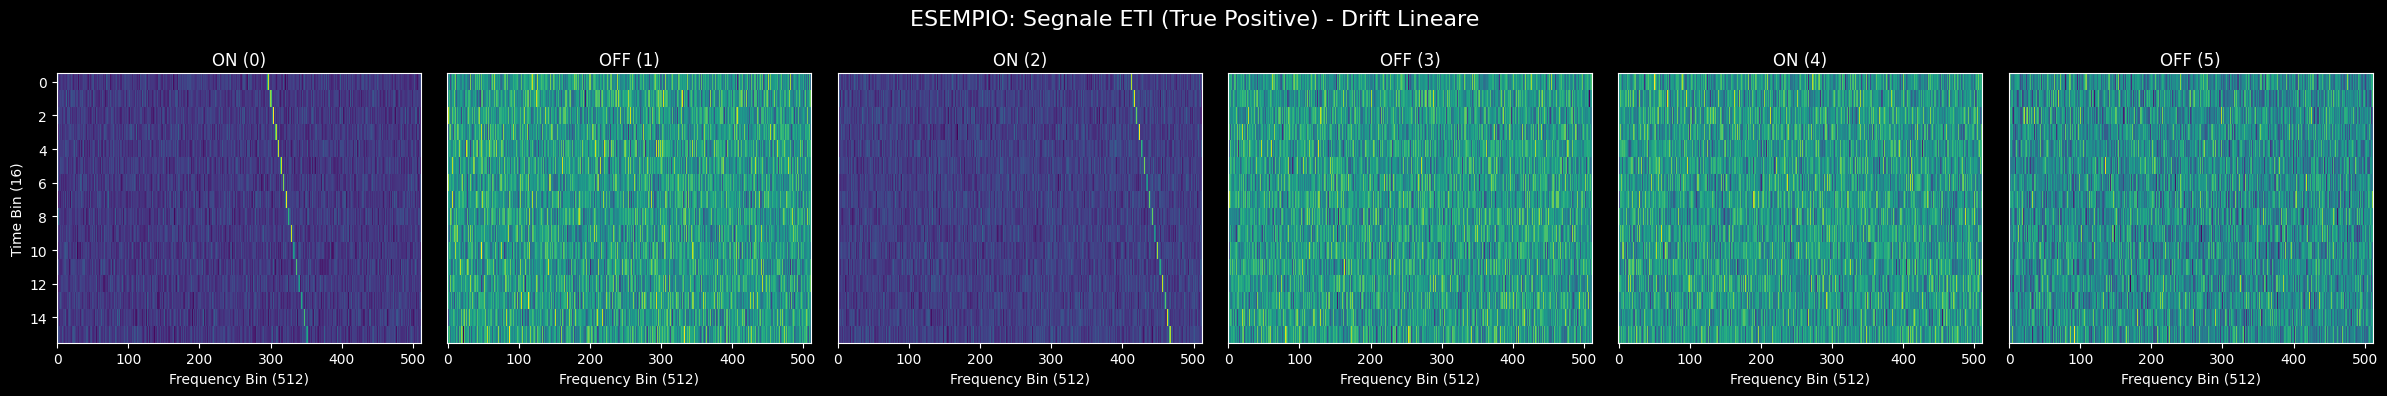

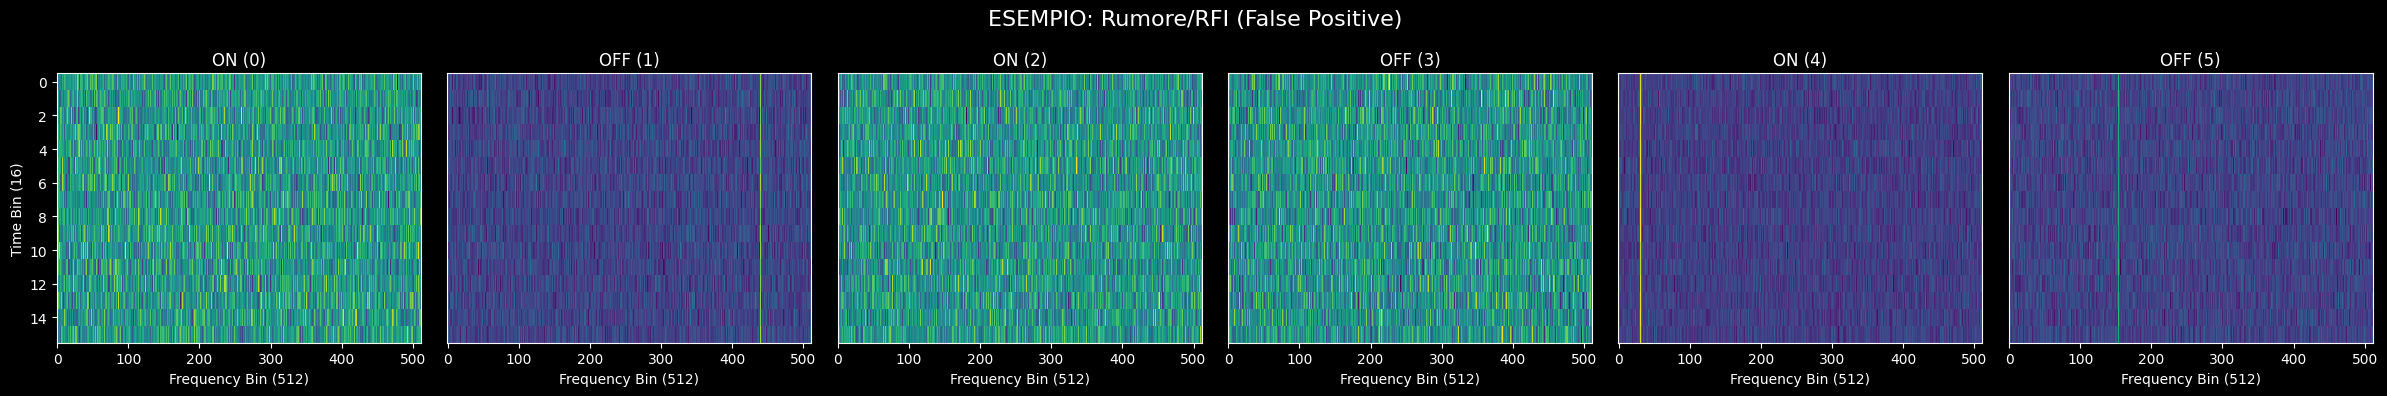

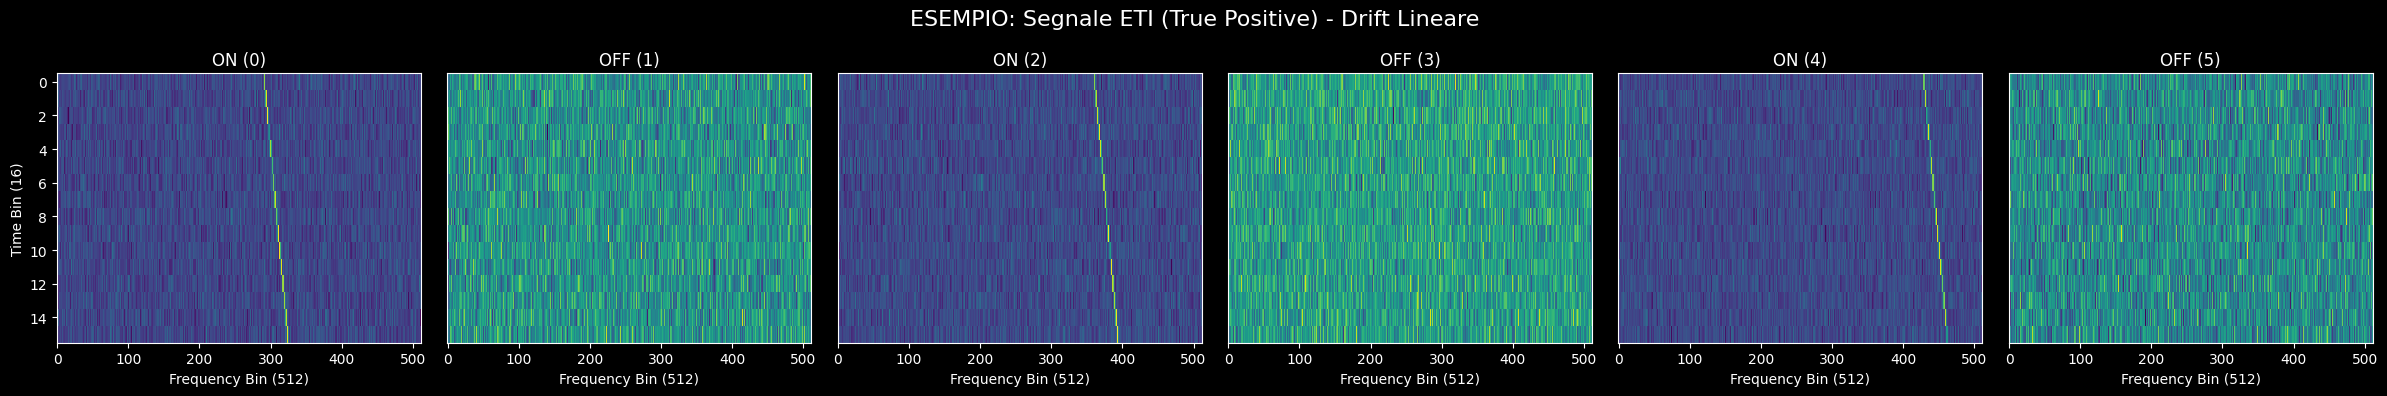


>>> Visualizzazione False Positive (RFI/Noise)...
    Dovresti vedere solo rumore o linee verticali (RFI) che non rispettano il pattern ON/OFF.


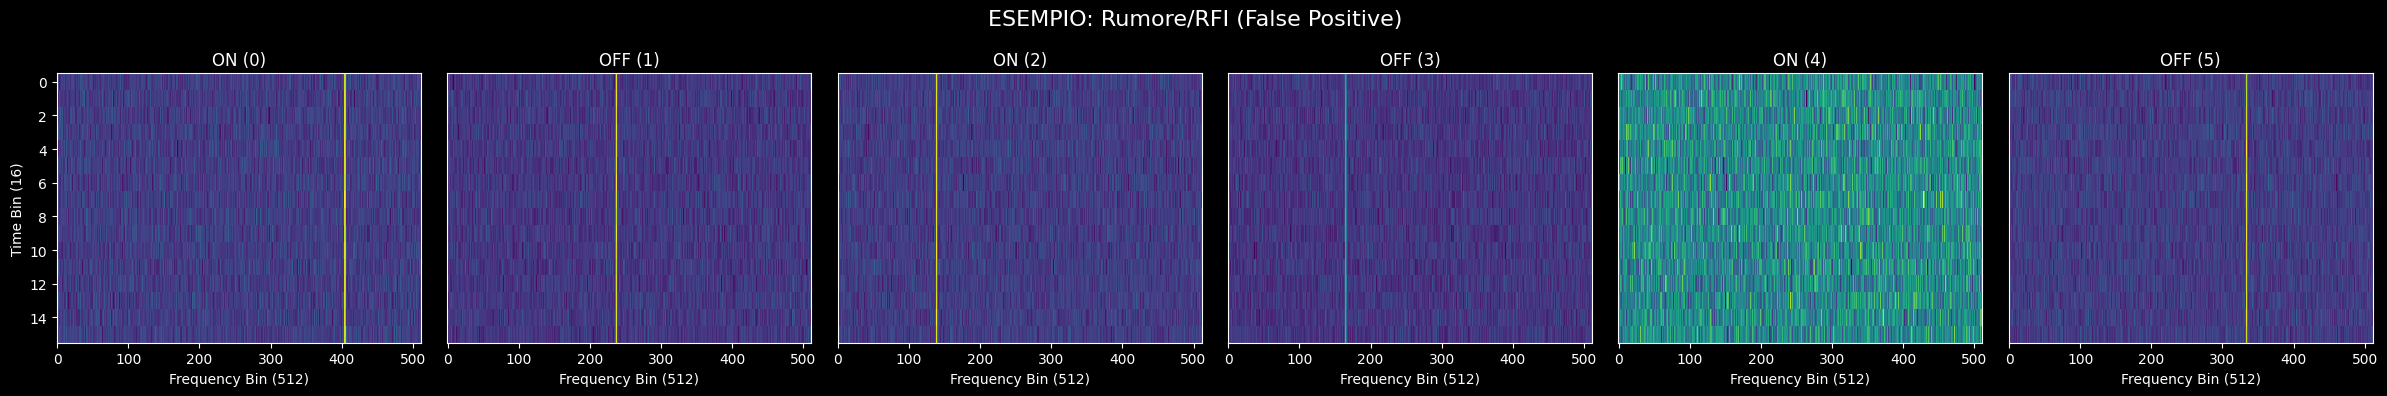

In [6]:
# ==========================================
# Verifica Generazione Dati SETI
# ==========================================
# Questo script serve per verificare visivamente che:
# 1. I dati sintetici vengano generati correttamente (Drift, SNR)
# 2. La logica ON-OFF sia rispettata (il segnale deve sparire negli scan dispari)
# 3. Il preprocessing (resize e normalizzazione) non distrugga l'informazione

import matplotlib.pyplot as plt
import numpy as np
from src.generator import SetiHybridGenerator
import sys

# Configurazione visualizzazione
plt.style.use('dark_background')

def plot_cadence(cadence_data, title="Cadence"):
    """
    Visualizza le 6 osservazioni di una cadenza.
    Input shape: (6, 16, 512, 1)
    """
    # Rimuoviamo l'ultima dimensione (canale) se presente
    if cadence_data.shape[-1] == 1:
        cadence_data = cadence_data[:, :, :, 0]

    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    fig.suptitle(title, fontsize=16, color='white')
    
    labels = ['ON (0)', 'OFF (1)', 'ON (2)', 'OFF (3)', 'ON (4)', 'OFF (5)']
    
    for i in range(6):
        img = cadence_data[i]
        
        ax = axes[i]
        # Aspect='auto' adatta i pixel alla finestra, interpolation='nearest' mostra i pixel reali
        cax = ax.imshow(img, aspect='auto', cmap='viridis', interpolation='nearest')
        
        ax.set_title(f"{labels[i]}", fontsize=12)
        ax.set_xlabel("Frequency Bin (512)", fontsize=10)
        if i == 0:
            ax.set_ylabel("Time Bin (16)", fontsize=10)
        else:
            ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

def main():
    print(">>> Inizializzazione SetiHybridGenerator (Modalità Sintetica)...")
    try:
        # Batch size piccolo per visualizzazione
        BATCH_SIZE = 4
        generator = SetiHybridGenerator(background_plates=None, batch_size=BATCH_SIZE)

        # Estraiamo il primo batch
        print(">>> Generazione Batch...")
        # Il generatore restituisce: ([mixed, true, false], mixed)
        (inputs, targets) = generator[0]

        mixed_batch = inputs[0]
        true_batch = inputs[1]
        false_batch = inputs[2]

        print(f"   [OK] Shape Mixed Batch: {mixed_batch.shape}")
        print(f"   [OK] Shape True Batch:  {true_batch.shape}")
        print(f"   [OK] Shape False Batch: {false_batch.shape}")

        # ==========================================
        # Visualizzazione Pattern ON-OFF (True Data)
        # ==========================================
        print("\n>>> Visualizzazione True Positive (ETI)...")
        print("    Dovresti vedere una linea obliqua negli scan 0, 2, 4.")
        plot_cadence(true_batch[0], title="ESEMPIO: Segnale ETI (True Positive) - Drift Lineare")

        # ==========================================
        # Visualizzazione RFI/Rumore (False Data)
        # ==========================================
        print("\n>>> Visualizzazione False Positive (RFI/Noise)...")
        print("    Dovresti vedere solo rumore o linee verticali (RFI) che non rispettano il pattern ON/OFF.")
        plot_cadence(false_batch[0], title="ESEMPIO: Rumore/RFI (False Positive)")
        
    except Exception as e:
        print(f"\n[ERRORE] Si è verificato un problema durante il test:\n{e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()